# Model generation of Resume data

## Setup Google colab

In [1]:
!bash setup.sh

Cloning into 'datartistry'...
remote: Enumerating objects: 988, done.
remote: Counting objects: 100% (988/988), done.
remote: Compressing objects: 100% (966/966), done.
remote: Total 3613 (delta 23), reused 963 (delta 12), pack-reused 2625
Receiving objects: 100% (3613/3613), 350.96 MiB | 28.19 MiB/s, done.
Resolving deltas: 100% (484/484), done.
Checking out files: 100% (4075/4075), done.


In [2]:
%cd datartistry

/content/datartistry


In [3]:
!git checkout -b modeling
!git push -u origin modeling

Switched to a new branch 'modeling'
Total 0 (delta 0), reused 0 (delta 0)
remote: 
remote: Create a pull request for 'modeling' on GitHub by visiting:
remote:      https://github.com/Inventrohyder/datartistry/pull/new/modeling
remote: 
To github.com:Inventrohyder/datartistry.git
 * [new branch]      modeling -> modeling
Branch 'modeling' set up to track remote branch 'modeling' from 'origin'.


## Begin Modeling

In [43]:
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [47]:
vocab_size = 10000
embedding_dim = 16
max_length = 570   # ~ The median value of the length of a resume
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [35]:
df = pd.read_csv('/content/datartistry/to_modeling.csv', index_col=0)
df = df.dropna()
df.head()

,category,cleaned_text
0,fund_accounting,QIAN BOWEN blankline Mobile: + 65 9060 7342 bl...
1,fund_accounting,Dina V. Nagao blankline E: DinaVNagao@gmail.co...
2,corporate_secretary,blankline newline newline EXPERIENCE blankline...
3,sales,blankline blankline blankline blankline blankl...
4,sales,"Terence Neo blankline Singaporean Chinese, bor..."


### Fund accounting model

In [40]:
df['is_fund_accounting'] = df['category'].apply(
    lambda x: 1 if x == "fund_accounting" else 0
)
df.head()

,category,cleaned_text,is_fund_accounting
0,fund_accounting,QIAN BOWEN blankline Mobile: + 65 9060 7342 bl...,1
1,fund_accounting,Dina V. Nagao blankline E: DinaVNagao@gmail.co...,1
2,corporate_secretary,blankline newline newline EXPERIENCE blankline...,0
3,sales,blankline blankline blankline blankline blankl...,0
4,sales,"Terence Neo blankline Singaporean Chinese, bor...",0


In [61]:
# Split into training and test sets
msk = np.random.rand(len(df)) < 0.8   # Split into 80% training

train = df[msk]

test = df[~msk]

In [65]:
training_resumes = train['cleaned_text']
testing_resumes = test['cleaned_text']

training_labels = train['is_fund_accounting']
testing_labels = test['is_fund_accounting']

In [62]:
# Generate a word index
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_resumes)

word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'newline': 2,
 'blankline': 3,
 'and': 4,
 'of': 5,
 'the': 6,
 'in': 7,
 'to': 8,
 '\uf0b7': 9,
 'for': 10,
 '•': 11,
 'with': 12,
 'a': 13,
 '–': 14,
 'management': 15,
 'on': 16,
 'financial': 17,
 'singapore': 18,
 'business': 19,
 'as': 20,
 'fund': 21,
 'investment': 22,
 'audit': 23,
 'team': 24,
 'company': 25,
 'accounting': 26,
 '\uf0a7': 27,
 'hong': 28,
 'kong': 29,
 'clients': 30,
 'by': 31,
 'university': 32,
 'services': 33,
 'finance': 34,
 'work': 35,
 'experience': 36,
 'including': 37,
 'skills': 38,
 'client': 39,
 'corporate': 40,
 'companies': 41,
 'analysis': 42,
 '1': 43,
 'funds': 44,
 '\u200b': 45,
 'new': 46,
 '2014': 47,
 'from': 48,
 '2013': 49,
 'group': 50,
 '2015': 51,
 '2012': 52,
 'reporting': 53,
 '2011': 54,
 'review': 55,
 'reports': 56,
 'compliance': 57,
 'office': 58,
 'com': 59,
 '3': 60,
 'manager': 61,
 'bank': 62,
 '2016': 63,
 'i': 64,
 '2010': 65,
 'equity': 66,
 'education': 67,
 'limited': 68,
 'e': 69,
 '2': 70,
 'all': 71,

In [64]:
training_sequences = tokenizer.texts_to_sequences(training_resumes)
training_padded = pad_sequences(
    training_sequences, 
    maxlen=max_length, 
    padding=padding_type, 
    truncating=trunc_type
)

testing_sequences = tokenizer.texts_to_sequences(testing_resumes)
testing_padded = pad_sequences(
    testing_sequences, 
    maxlen=max_length, 
    padding=padding_type, 
    truncating=trunc_type
)

In [66]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [106]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [107]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 570, 16)           160000    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [108]:
num_epochs = 20
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/20
24/24 - 0s - loss: 0.6915 - accuracy: 0.5587 - val_loss: 0.6874 - val_accuracy: 0.5892
Epoch 2/20
24/24 - 0s - loss: 0.6876 - accuracy: 0.5627 - val_loss: 0.6819 - val_accuracy: 0.5892
Epoch 3/20
24/24 - 0s - loss: 0.6820 - accuracy: 0.5627 - val_loss: 0.6769 - val_accuracy: 0.5892
Epoch 4/20
24/24 - 0s - loss: 0.6747 - accuracy: 0.5627 - val_loss: 0.6692 - val_accuracy: 0.5892
Epoch 5/20
24/24 - 0s - loss: 0.6612 - accuracy: 0.5627 - val_loss: 0.6584 - val_accuracy: 0.5892
Epoch 6/20
24/24 - 0s - loss: 0.6394 - accuracy: 0.5840 - val_loss: 0.6415 - val_accuracy: 0.6108
Epoch 7/20
24/24 - 0s - loss: 0.6088 - accuracy: 0.6560 - val_loss: 0.6214 - val_accuracy: 0.6324
Epoch 8/20
24/24 - 0s - loss: 0.5718 - accuracy: 0.7707 - val_loss: 0.5988 - val_accuracy: 0.6703
Epoch 9/20
24/24 - 0s - loss: 0.5300 - accuracy: 0.8040 - val_loss: 0.5780 - val_accuracy: 0.6757
Epoch 10/20
24/24 - 0s - loss: 0.4877 - accuracy: 0.8373 - val_loss: 0.5601 - val_accuracy: 0.6865
Epoch 11/20
24/24 -

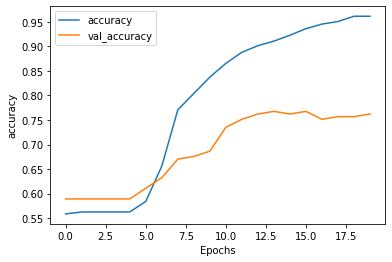

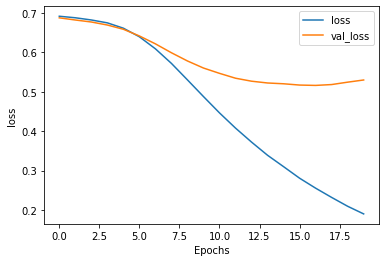

In [109]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [110]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_resume(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_resume(training_padded[0]))
print(training_resumes[2])
print(training_labels[2])

dina v nagao blankline e dinavnagao gmail com blankline • newline • blankline • newline • newline • blankline • blankline • newline • blankline • newline • blankline • blankline • blankline experience newline fund controller contractor vice president newline blackrock asset management north asia limited – hong kong blankline february 2017 – may 2017 blankline focused primarily on administration of real estate funds in divestment cycle newline contracted and liaised with liquidators of various jurisdictions to initiate timely wind up of funds’ newline entities newline coordinated annual audit and tax filing with relevant parties newline reviewed annual financial statements with emphasis on liquidation basis newline compiled a set of guidelines with regards to liquidation procedures to be followed in the future blankline fund administration manager officer newline state street fund services singapore pte limited – singapore blankline september 2013 – august 2016 blankline • maintained da

In [111]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


### Save the model features

In [115]:
import io
import pickle

# saving the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the embeddings
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

# Save the model
model.save('/content/datartistry/fund_accounting')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/datartistry/fund_accounting/assets


### Testing out our model by loading the model parameters

In [116]:
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

model = tf.keras.models.load_model('/content/datartistry/fund_accounting') 

In [117]:
resume = [df['cleaned_text'][3]]
sequence = tokenizer.texts_to_sequences(resume)
padded = pad_sequences(
    sequence, 
    maxlen=max_length, 
    padding=padding_type, 
    truncating=trunc_type
)
prediction = model.predict(padded)
print(prediction)
print(df['is_fund_accounting'][3])

[[0.05451611]]
0


In [118]:
resume = [df['cleaned_text'][7]]
sequence = tokenizer.texts_to_sequences(resume)
padded = pad_sequences(
    sequence, 
    maxlen=max_length, 
    padding=padding_type, 
    truncating=trunc_type
)
prediction = model.predict(padded)
print(prediction)
print(df['is_fund_accounting'][7])

[[0.805751]]
1
